# EDA – freMTPL2 (Counts)

**Ziel:** Schneller Überblick zur Schadenfrequenz (Counts) mit **Exposure**-Bezug, analog Schelldorfer & Wüthrich (2019).  
**Grundprinzip:** Wir arbeiten **exposure-gewichtet** und filtern **kleine Gruppen** (≥100 PY), um Rauschen zu vermeiden.  
**Preprocessing:** ClaimNb≤4, Exposure≤1, DrivAge≤90, VehAge≤40 (nur für EDA/Robustheit), B12-Neuwagen ggf. ausgeschlossen, BM bis 125%.

**KPI:**
- Policen: 678013
- Gesamt-Exposure (PY): 358360.105462
- Zero-Rate (Anteil ClaimNb=0): 0.949765
- Overall Frequency: 0.100614 (ΣClaims / ΣExposure)


In [7]:
import pandas as pd
path = "../data/work/freMTPL2_joined_capped.parquet"
df = pd.read_parquet(path)

In [8]:

kpi = {
    "policies": int(len(df)),
    "exposure_total": float(df["Exposure"].sum()),
    "zero_rate": float((df["ClaimNb"]==0).mean()),
    "overall_frequency": float(df["ClaimNb"].sum() / df["Exposure"].sum()),
    "mean_exposure": float(df["Exposure"].mean()),
}
pd.Series(kpi).to_frame("value")


,value
policies,678013.000000
exposure_total,358360.105462
zero_rate,0.963210
overall_frequency,0.073683
mean_exposure,0.528545


In [9]:
df["Frequency"] = df["ClaimNb"] / df["Exposure"]


zero_rate = (df["ClaimNb"] == 0).mean()
freq_desc = df["Frequency"].describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99])

{
    "rows": len(df),
    "zero_rate": float(zero_rate),
    "frequency_summary": freq_desc.to_dict()
}

{'rows': 678013,
 'zero_rate': 0.9632101449382239,
 'frequency_summary': {'count': 678013.0,
  'mean': 0.11816806040837116,
  'std': 2.005519950095346,
  'min': 0.0,
  '50%': 0.0,
  '75%': 0.0,
  '90%': 0.0,
  '95%': 0.0,
  '99%': 2.269662921348434,
  'max': 365.00000365000005}}

In [10]:
qual = pd.DataFrame({
    "missing_pct": df.isna().mean().sort_values(ascending=False),
    "dtype": df.dtypes.astype(str)
})
qual.head(13)


,missing_pct,dtype
IDpol,0.0,Int64
Exposure,0.0,float64
VehPower,0.0,int64
VehAge,0.0,int64
DrivAge,0.0,int64
BonusMalus,0.0,int64
VehBrand,0.0,category
VehGas,0.0,category
Area,0.0,category
Density,0.0,int64


In [11]:
cats = [c for c in ["VehBrand","VehGas","Area","Region"] if c in df]
card = pd.Series({c: df[c].nunique(dropna=True) for c in cats}).sort_values(ascending=False)
card.to_frame("n_levels")


,n_levels
Region,21
VehBrand,11
Area,6
VehGas,2


## Metrik & Aggregation

**Frequenz je Gruppe:**  
$$
\hat{\lambda}_g \;=\; \frac{\sum_{i \in g} \text{ClaimNb}_i}{\sum_{i \in g} \text{Exposure}_i}
$$
Das ist der MLE der Poisson-Rate – **keine** Mittelung von Einzel-Frequenzen.  
**Unsicherheit (Screening):** $\text{se} \approx \sqrt{\sum \text{ClaimNb}} / \sum \text{Exposure}$ → 95%-Intervall ≈ freq ± 1.96·se.  
**Stabilität:** Nur Gruppen mit **min. Exposure ≥ 100** werden geplottet/tabelliert.


In [12]:
def freq_by(df, group_cols, min_exposure=100, mask=None):
    g = df if mask is None else df.loc[mask]
    agg = (g.groupby(group_cols, observed=False)
             .agg(expo=("Exposure","sum"), claims=("ClaimNb","sum"))
             .reset_index())
    agg["freq"] = agg["claims"] / agg["expo"]
    return agg.loc[agg["expo"] >= min_exposure].sort_values("freq", ascending=False)


In [13]:
tab = freq_by(df, ["VehBrand","VehGas"], 100).copy()
tab["se"] = (tab["claims"].clip(lower=1)**0.5) / tab["expo"]
tab["lo"] = (tab["freq"] - 1.96*tab["se"]).clip(lower=0)
tab["hi"] = tab["freq"] + 1.96*tab["se"]
tab.sort_values("freq", ascending=False).head(15)

,VehBrand,VehGas,expo,claims,freq,se,lo,hi
4,B11,Diesel,3305.040699,328,0.099242,0.005480,0.088502,0.109983
5,B11,Regular,3578.036580,336,0.093906,0.005123,0.083865,0.103947
20,B6,Diesel,5822.897376,539,0.092566,0.003987,0.084751,0.100380
14,B3,Diesel,15399.160248,1375,0.089291,0.002408,0.084571,0.094010
8,B13,Diesel,3281.825636,291,0.088670,0.005198,0.078482,0.098858
18,B5,Diesel,9461.237819,823,0.086987,0.003032,0.081043,0.092930
16,B4,Diesel,5877.463830,504,0.085751,0.003820,0.078265,0.093238
2,B10,Diesel,6959.990597,591,0.084914,0.003493,0.078068,0.091760
15,B3,Regular,13177.276083,1054,0.079986,0.002464,0.075157,0.084815
19,B5,Regular,10522.364875,839,0.079735,0.002753,0.074340,0.085130


## Brand × Fuel (exposure-gewichtet)

**Frage:** Welche Marken/Antriebe liegen bei der Frequenz vorn, wenn wir Exposure berücksichtigen?  
**Methode:** Gruppieren nach *(VehBrand, VehGas)* → ΣClaims/ΣExposure, min Exposure ≥100.  

- Ist **B12** auffällig? (Quelle berichtet „B12-Neuwagen-Effekt“ und Datenbereinigung)
- Diesel vs. Regular: konsistenter Shift?

_Kurzbefund :_ B12 in regular übermäßig häufig vertreten


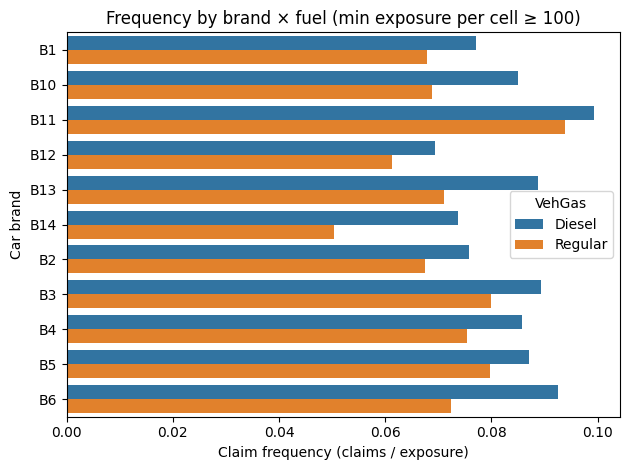

In [16]:
import seaborn as sns
from matplotlib import pyplot as plt

agg_bfuel = freq_by(df, ["VehBrand","VehGas"], min_exposure=100)
top = agg_bfuel.sort_values("freq", ascending=False)

plt.figure()
sns.barplot(data=top, x="freq", y="VehBrand", hue="VehGas")
plt.xlabel("Claim frequency (claims / exposure)")
plt.ylabel("Car brand")
plt.title("Frequency by brand × fuel (min exposure per cell ≥ 100)")
plt.tight_layout()
plt.savefig("../reports/figs/A_brand_fuel.png", dpi=200, bbox_inches="tight")


## Vehicle age × Bonus-Malus (BM≤125)

**Frage:** Interagieren Fahrzeugalter und Bonus-Malus-Stufe?  
**Methode:** BM in 25er-Stufen (≤125), VehAge 0..19 + **20+**, **B12-Neuwagen** ausgeschlossen; Frequenz je Zelle, LOWESS-Glättung mit Band.  

- Systematische Level-Unterschiede zwischen BM-Stufen
- Form über VehAge 
- Schwankungen am Rand = oft wenig Exposure → breite Bänder

_Kurzbefund:_ frequency sinkt tendenziell mit zunehmenden Alter des Fahrzeug, bei hohen Malus ist ein Maximum bei VehAge=10 zu erkennen, also eher nicht monoton wie bei den anderen Malus

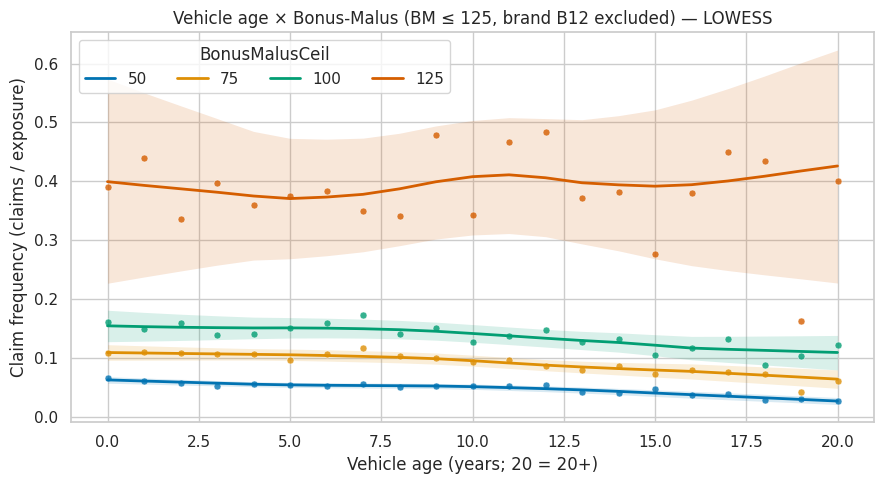

In [18]:
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess

tmp = df.loc[(df["VehBrand"] != "B12") & (df["BonusMalus"] <= 125)].copy()
tmp["VehAge"] = np.minimum(tmp["VehAge"], 20).astype(int)  # 20 = 20+
tmp["BonusMalusCeil"] = (np.ceil(tmp["BonusMalus"] / 25) * 25).astype(int).astype(str)

agg = (tmp.groupby(["VehAge", "BonusMalusCeil"])
          .agg(Exposure=("Exposure","sum"), ClaimNb=("ClaimNb","sum"))
          .reset_index())
agg["claim_frequency"] = agg["ClaimNb"] / agg["Exposure"]
# Poisson-Approx für Unsicherheit pro Punkt:
agg["se"] = np.sqrt(agg["ClaimNb"].clip(lower=1)) / agg["Exposure"]

# Reihenfolge der BM-Linien (wie in deinem Screenshot)
bm_order = sorted(agg["BonusMalusCeil"].unique(), key=lambda x: int(x))
colors = sns.color_palette("colorblind", n_colors=len(bm_order))

# Plot mit LOWESS und Konfidenzbändern 
sns.set_theme(style="whitegrid")
plt.figure(figsize=(9,5))

FRAC = 0.5  # Glättungsgrad 

for color, bm in zip(colors, bm_order):
    sub = agg.loc[agg["BonusMalusCeil"] == bm].sort_values("VehAge")
    x = sub["VehAge"].to_numpy()
    y = sub["claim_frequency"].to_numpy()
    se = sub["se"].to_numpy()

    # LOWESS der Mittelkurve
    y_hat = lowess(y, x, frac=FRAC, return_sorted=False)

    # "Konfidenzband": LOWESS auf (y +- 1.96*se)
    y_hi = lowess((y + 1.96*se), x, frac=FRAC, return_sorted=False)
    y_lo = lowess(np.clip(y - 1.96*se, 0, None), x, frac=FRAC, return_sorted=False)

    # Fläche + Linie + Punkte
    plt.fill_between(x, y_lo, y_hi, color=color, alpha=0.15, linewidth=0)
    plt.plot(x, y_hat, color=color, linewidth=2, label=bm)
    plt.scatter(x, y, color=color, s=25, alpha=0.8, edgecolor="white", linewidth=0.4)

plt.xlabel("Vehicle age (years; 20 = 20+)")
plt.ylabel("Claim frequency (claims / exposure)")
plt.title("Vehicle age × Bonus-Malus (BM ≤ 125, brand B12 excluded) — LOWESS")
plt.legend(title="BonusMalusCeil", ncol=len(bm_order),  loc="upper left")
plt.savefig("../reports/figs/B_vehage_bm_lowess.png", dpi=200, bbox_inches="tight")
plt.tight_layout()
plt.show()

## Vehicle age × Fuel

**Frage:** Wie verläuft die Frequenz über das Fahrzeugalter je Antrieb?  
**Methode:** VehAge in **0..19** einzelne Jahre, **20+** gebündelt; min Exposure ≥100.  

_Kurzbefund:_ monotoner Trend erkennbar, hohe claim frequency bei neuen Fahrzeugen (regular+diesel)


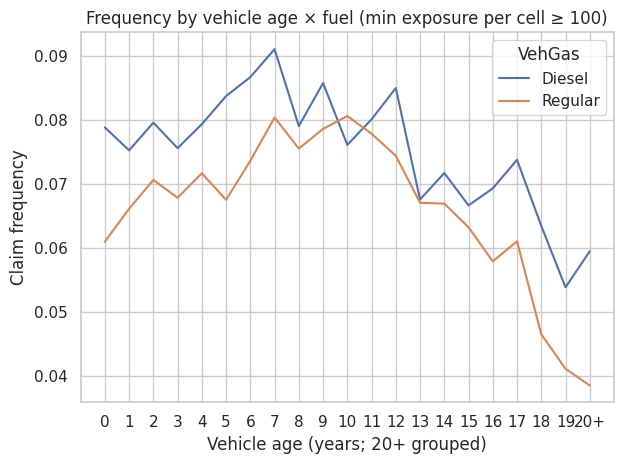

In [19]:
# definierte Alters-Band-Reihenfolge
order_age = [str(i) for i in range(0, 20)] + ["20+"]

# VehAge -> Bänder: 0..19 einzeln, >=20 -> "20+"
veh_age_band = df["VehAge"].clip(upper=20).astype(int).astype(str)
veh_age_band[df["VehAge"] >= 20] = "20+"
veh_age_band = pd.Categorical(veh_age_band, categories=order_age, ordered=True)

# Aggregation mit kategorischem VehAgeBand
agg_agefuel = freq_by(
    df.assign(VehAgeBand=veh_age_band),
    ["VehAgeBand", "VehGas"],
    min_exposure=100
)

# sicherstellen, dass die Kategorie auch im Aggregat erhalten bleibt
agg_agefuel["VehAgeBand"] = agg_agefuel["VehAgeBand"].astype("category").cat.set_categories(order_age, ordered=True)

# Plot: sortiere nach der Kategorie
plt.figure()
sns.lineplot(
    data=agg_agefuel.sort_values("VehAgeBand"),
    x="VehAgeBand", y="freq", hue="VehGas"
)
plt.xlabel("Vehicle age (years; 20+ grouped)")
plt.ylabel("Claim frequency")
plt.title("Frequency by vehicle age × fuel (min exposure per cell ≥ 100)")
plt.tight_layout()
plt.show()


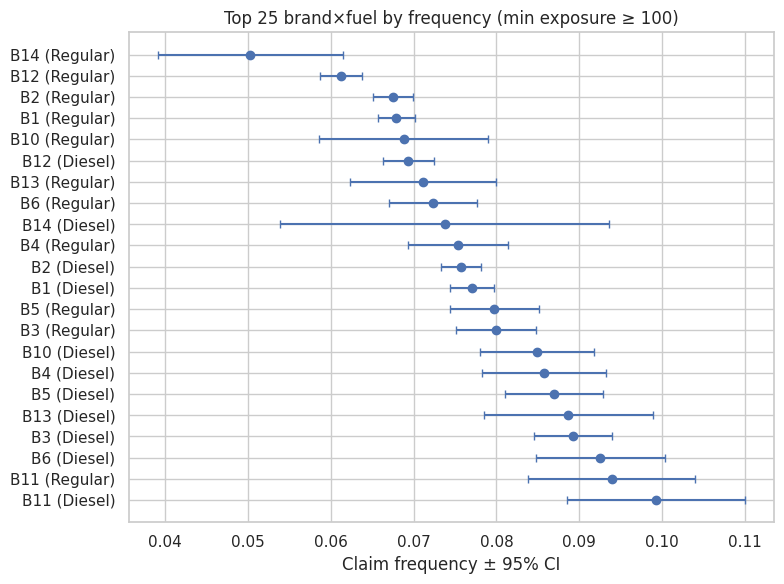

In [20]:
agg = freq_by(df, ["VehBrand","VehGas"], min_exposure=100)
agg["se"] = np.sqrt(agg["claims"]) / agg["expo"]
agg["lo"] = np.clip(agg["freq"] - 1.96*agg["se"], 0, None)
agg["hi"] = agg["freq"] + 1.96*agg["se"]

# Top 25 nach Frequenz
plot = agg.sort_values("freq", ascending=False).head(25).copy()

# Labels: Categorical -> String
labels = (plot["VehBrand"].astype(str) + " (" + plot["VehGas"].astype(str) + ")").tolist()

# x, y und Fehler als Arrays
x = plot["freq"].to_numpy()
y = np.arange(len(plot))
xerr = np.vstack([(plot["freq"] - plot["lo"]).to_numpy(),
                  (plot["hi"]   - plot["freq"]).to_numpy()])

plt.figure(figsize=(8,6))
plt.errorbar(x, y, xerr=xerr, fmt="o", capsize=3)
plt.yticks(y, labels)
plt.xlabel("Claim frequency ± 95% CI")
plt.title("Top 25 brand×fuel by frequency (min exposure ≥ 100)")
plt.tight_layout()
plt.show()

## Driver age × Bonus-Malus (BM≤125)

**Frage:** Gibt es monotone Effekte des Fahrer-Alters je BM-Stufe?  
**Methode:** DrivAge in 5-Jahres-Bins, 85=85+; BM in 25er-Stufen (≤125); Frequenz je (AgeBin, BM), LOWESS mit Band.  
 
- Steigt die Frequenz im hohen Alter? 
- Breite Bänder am Rand = wenig Exposure

_Kurzbefund:_ U-Förmige plots erkennbar


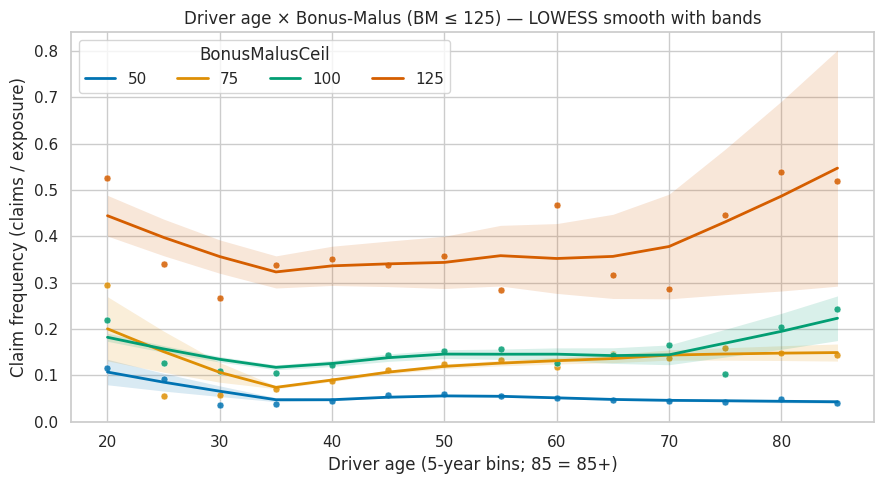

In [21]:
# Filter 
tmp = df.loc[df["BonusMalus"] <= 125].copy()

# Driver age in 5er-Schritten, 85 = 85+
tmp["DrivAge5"] = (np.ceil(np.minimum(tmp["DrivAge"], 85) / 5) * 5).astype(int)

# BonusMalus in 25er-Stufen; behalte INT zum Sortieren + STRING für die Legende
tmp["BM"]       = (np.ceil(tmp["BonusMalus"] / 25) * 25).astype(int)
tmp["BM_label"] = tmp["BM"].astype(str)

# Aggregation: exposure-gewichtete Frequenz + Standardfehler (Poisson-Approx)
agg = (tmp.groupby(["DrivAge5", "BM"], as_index=False)
         .agg(expo=("Exposure","sum"), claims=("ClaimNb","sum")))
agg["freq"] = agg["claims"] / agg["expo"]
agg["se"]   = np.sqrt(agg["claims"].clip(lower=1)) / agg["expo"]
agg["BM_label"] = agg["BM"].astype(str)

# Plot mit LOWESS und Bändern (wie geom_smooth())
sns.set_theme(style="whitegrid")
plt.figure(figsize=(9,5))

bm_order = sorted(agg["BM"].unique())                         # numerische Reihenfolge der BM-Stufen
colors   = sns.color_palette("colorblind", n_colors=len(bm_order))
FRAC     = 0.53                                                # Glättungsgrad 

for color, bm in zip(colors, bm_order):
    sub = agg.loc[agg["BM"] == bm].sort_values("DrivAge5")
    x   = sub["DrivAge5"].to_numpy()
    y   = sub["freq"].to_numpy()
    se  = sub["se"].to_numpy()

    # LOWESS der Mittelkurve
    y_hat = lowess(y, x, frac=FRAC, return_sorted=False, it = 0)

    # "Konfidenzband": LOWESS auf (y ± n*se)
    y_hi = lowess(y + 1.2*se, x, frac=FRAC, return_sorted=False, it = 0)
    y_lo = lowess(np.clip(y - 1.2*se, 0, None), x, frac=FRAC, return_sorted=False, it = 0)

    # Fläche + Linie + Punkte
    plt.fill_between(x, y_lo, y_hi, color=color, alpha=0.15, linewidth=0)
    plt.plot(x, y_hat, color=color, linewidth=2, label=str(bm))
    plt.scatter(x, y, color=color, s=25, alpha=0.85, edgecolor="white", linewidth=0.4)

plt.xlabel("Driver age (5-year bins; 85 = 85+)")
plt.ylabel("Claim frequency (claims / exposure)")
plt.title("Driver age × Bonus-Malus (BM ≤ 125) — LOWESS smooth with bands")
plt.legend(title="BonusMalusCeil", ncol=min(len(bm_order), 6), loc="upper left")
plt.tight_layout()
plt.savefig("../reports/figs/C_drivage_bm_lowess_weighted.png", dpi=200, bbox_inches="tight")
plt.show()

## Verteilung: Driver age ~ ClaimNb (Violin), facettiert nach BM

**Frage:** Wie unterscheidet sich die Verteilung des Fahrer-Alters je Claim-Anzahl innerhalb der BM-Facets?  
**Methode:** BM≤125, ClaimNb<4, Facets nur mit ausreichendem Exposure; Violin mit Quartilen.  

- Median/Quartile verschieben sich mit ClaimNb?
- Facet-Wechsel: deutet auf Interaktionen hin

_Kurzbefund:_ 
- Bei niedrigen Malus (BM=50) eher bei 40-60 Jahren
- Bei BM=75 etc sinkt das Alter monoton => höherer Malus zeigen mehr Schäden bei jüngeren Fahrern

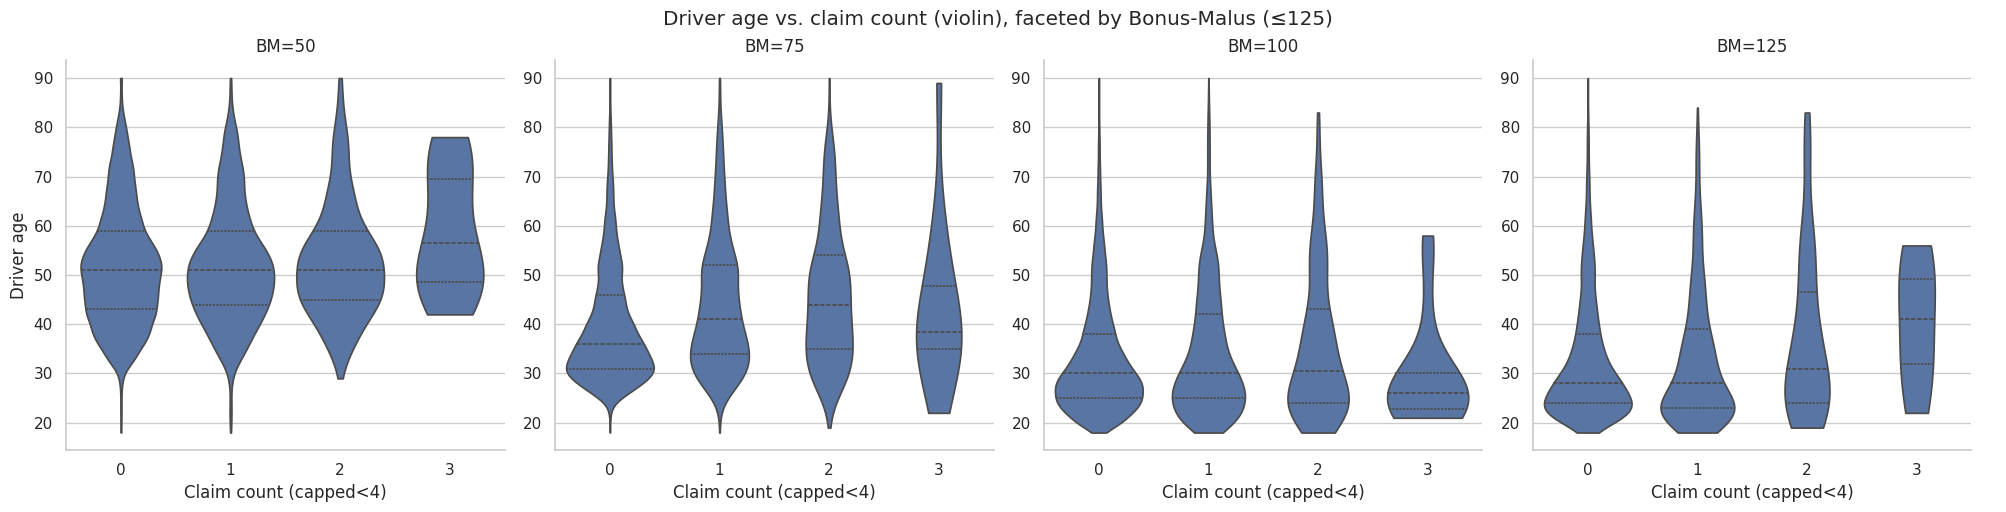

In [22]:
# Welche BM-Facets haben genügend Exposure?
BM = (np.ceil(df["BonusMalus"] / 25) * 25).clip(upper=125).astype(int)  # normale ints
bm_expo = df.groupby(BM).agg(expo=("Exposure","sum"))["expo"]
keep_bm = bm_expo[bm_expo >= 100].index


vi = df.loc[(df["BonusMalus"] <= 125) & (df["ClaimNb"] < 4) & (BM.isin(keep_bm))].copy()
vi["BonusMalusCeil"] = BM.astype(int)
vi["ClaimNbCat"] = vi["ClaimNb"].astype("category")

g = sns.catplot(
    data=vi,
    kind="violin",
    x="ClaimNbCat", y="DrivAge",
    col="BonusMalusCeil", col_wrap=4,
    cut=0, inner="quartile", sharey=False, height=5
)
g.set_axis_labels("Claim count (capped<4)", "Driver age")
g.set_titles("BM={col_name}")
g.fig.suptitle("Driver age vs. claim count (violin), faceted by Bonus-Malus (≤125)", y=1.02)
g.savefig("../reports/figs/D_violin_drivage_claims_by_bm.png", dpi=200, bbox_inches="tight")

